In [1]:
import numpy as np
import matplotlib.pyplot as plt
import starry
starry.config.lazy = False
starry.config.quiet = True

# Load the 8-bin optimal spectrum data
# data = np.load('inputs/spec_lambin_opt08.npz')
data = np.load('inputs/spec_lambin_25.npz')

# Extract arrays
# Based on convert.py for opt08:
# arr_0: time
# arr_1: wavelengths
# arr_2: bin widths (dlam)
# arr_3: raw flux
# arr_4: raw error

time = data['arr_0']
# time_mask = np.arange(len(time)//4, 4*len(time)//5)
time_mask = np.arange(len(time))
time = time[time_mask]
wl = data['arr_1']
nwl = len(wl)
# Apply scaling and transpose to get (n_time, n_wl)
# convert.py uses: flux = (data['arr_3'] * 1e-6) + 1
flux = (data['arr_2'].T * 1e-6) + 1
flux_err = (data['arr_3'].T * 1e-6)
flux = flux[time_mask, :].T
flux_err = flux_err[time_mask, :].T
print(f"Time shape: {time.shape}")
print(f"Wavelengths shape: {wl.shape}")
print(f"Flux shape: {flux.shape}")
print(f"Error shape: {flux_err.shape}")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Time shape: (2719,)
Wavelengths shape: (25,)
Flux shape: (25, 2719)
Error shape: (25, 2719)


/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,    
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
    "figure.dpi": 300,
    "figure.figsize": (3.5, 2.5),  # ApJ column width ~3.5 in; double column ~7 in
})
import spectralmap
print(f"spectralmap version: {spectralmap.__version__}")

spectralmap version: 0.1.0


In [3]:
# Star Parameters
m_star = 1.5596
r_star = 1.347
prot_star = 100

A = dict(
    ydeg=1,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=90,  # inclination in degrees
    amp=1.0,  # amplitude (a value prop. to luminosity)
    r=r_star,  #  radius in R_sun
    m=m_star,  # mass in M_sun
    prot=prot_star,  # rotational period in days
    u=[0.40, 0.25],  # limb darkening coefficients
)

# Planet Parameters (WASP-18b)
porb = 0.941452382

B = dict(
    ydeg=2,  # degree of the map
    udeg=2,  # degree of the limb darkening
    inc=84.38,  # inclination in degrees
    r=0.13177701,  #  radius in R_sun
    m=0.009956036,  #  mass in M_sun
    porb=porb,  # orbital period in days
    prot=porb,  # rotational period in days (sychronized)
    t0=2459802.4078798564,  # reference time in days (when it transits A)
    u=[0.0, 0.0],  # limb darkening coefficients
    Omega=0,
    ecc=0,
    w=269
)

In [4]:
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=90, amp=A["amp"]),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)

In [5]:
sec = starry.Secondary(
    starry.Map(ydeg=2, udeg=B["udeg"], inc=90),
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"], # time of transit
    inc=B["inc"],
    theta0=180.0,  # phase offset in degrees
)

In [6]:
np.savez('WASP18b_NIRISS.npz', time=time, flux=flux, flux_err=flux_err, wl=wl)

In [7]:
time, flux, flux_err, wl = np.load('WASP18b_NIRISS.npz').values()

In [8]:
from spectralmap.mapping import LightCurveData
data = LightCurveData(theta = time, flux=flux, flux_err=flux_err, wavelength=wl)

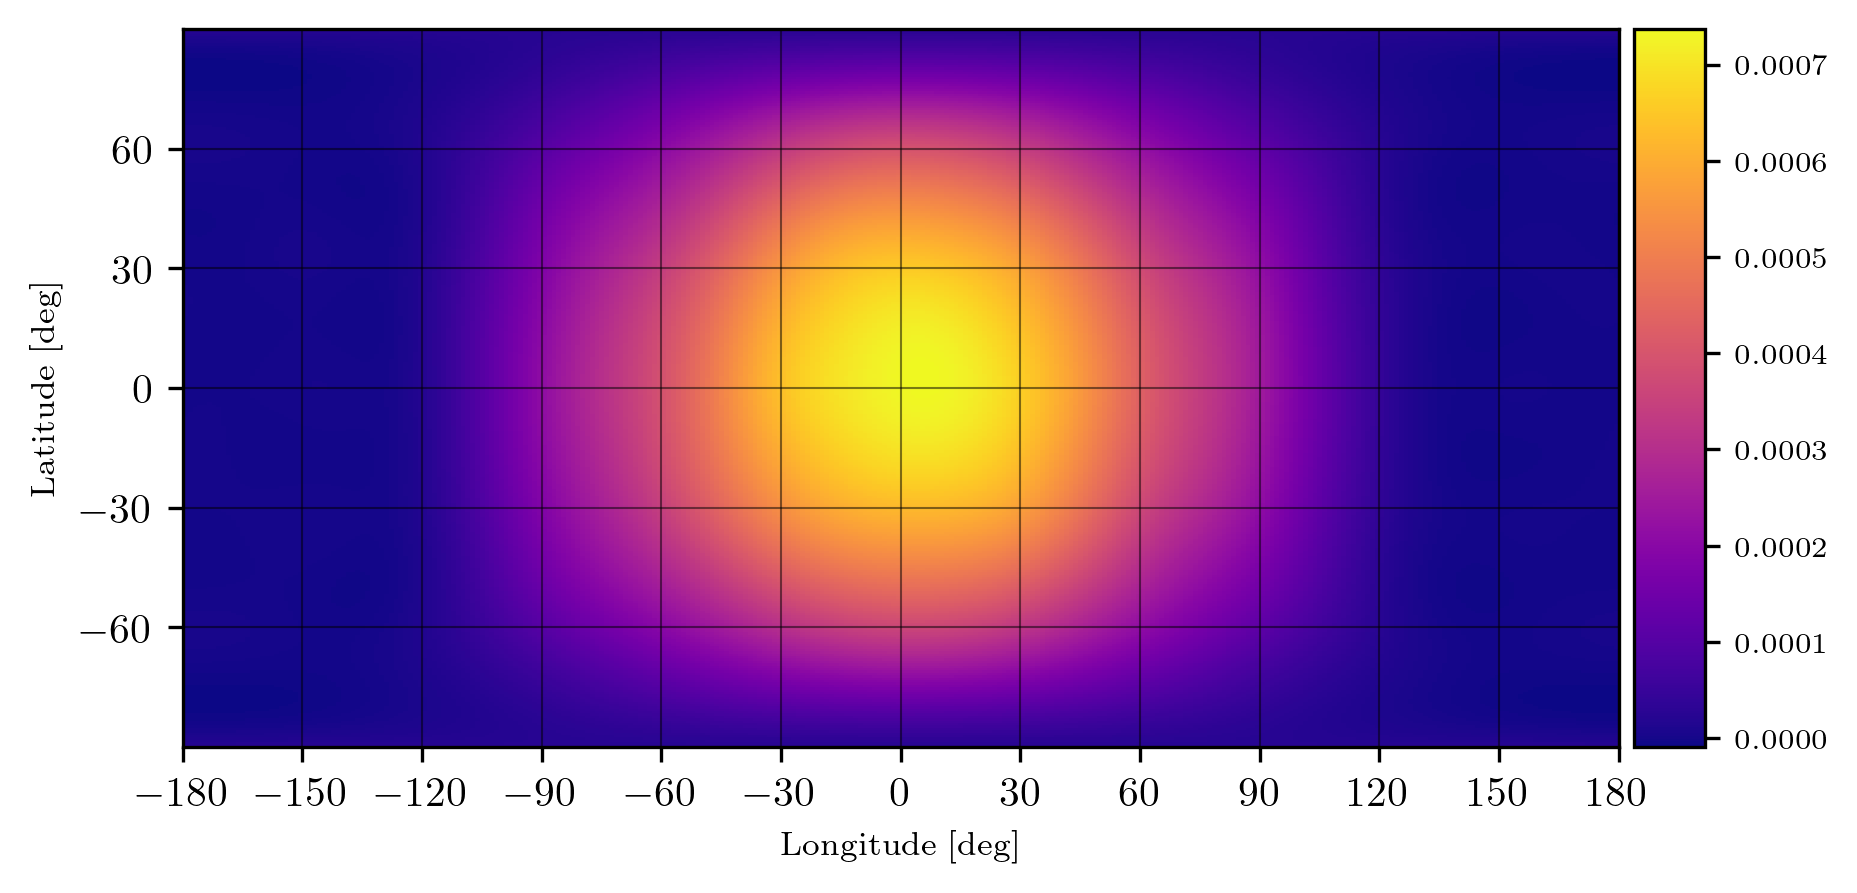

In [9]:
from spectralmap.mapping import make_maps, make_map
i_wl = 13
map = make_map(mode="eclipse", pri=pri, sec=sec, map_res=30, ydeg=10, observed_lon_range=(-151.8, 134.7))
map.get_latlon_grid()
mu, cov, log_ev = map.solve_posterior(flux[i_wl], flux_err[i_wl], theta=time, lambda_fix=1e9)
map.show(colorbar=True, projection='rect')

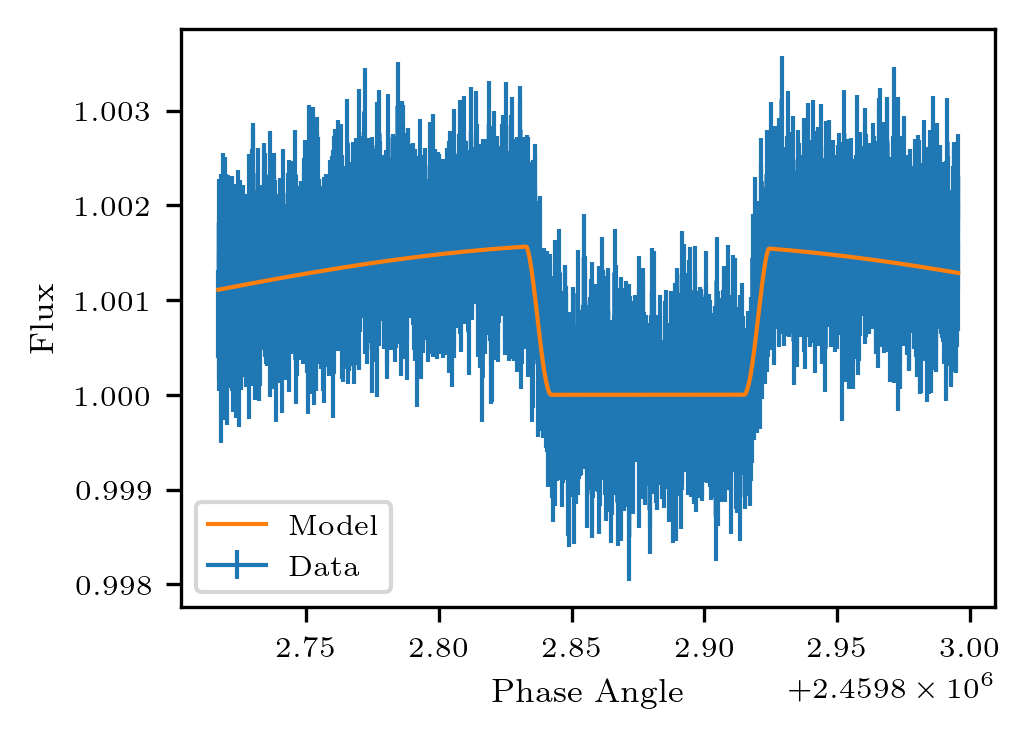

In [10]:
map.plot_lightcurve()

In [11]:
from spectralmap.utilities import expand_moll_values
I_mu = map.intensity_design_matrix_ @ mu
I_cov = map.intensity_design_matrix_ @ cov @ map.intensity_design_matrix_.T
I_err = np.sqrt(np.diag(I_cov))
sum(expand_moll_values(I_mu, map.observed_mask).reshape(30,30).sum(axis=0) < 0)

0

In [14]:
maps = make_maps(mode='eclipse', pri=pri, sec=sec, map_res=30, ydegs=np.arange(2, 3, 1), lambdas=np.logspace(7.5, 10, 10), eclipse_depth=0.0045, a_lambda=1e-10, b_lambda=1e-10, observed_lon_range=(-120, 120))

In [15]:
w_all, I_all_wl, I_cov_all_wl = maps.marginalized_maps(data)

lambda:  10%|█         | 1/10 [00:03<00:29,  3.23s/it]

lambda=31622776.60168379: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  20%|██        | 2/10 [00:03<00:14,  1.76s/it]

lambda=59948425.03189409: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  30%|███       | 3/10 [00:04<00:08,  1.25s/it]

lambda=113646366.63857242: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  40%|████      | 4/10 [00:05<00:06,  1.03s/it]

lambda=215443469.00318867: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  50%|█████     | 5/10 [00:05<00:04,  1.12it/s]

lambda=408423865.26745176: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  60%|██████    | 6/10 [00:06<00:03,  1.25it/s]

lambda=774263682.6811278: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  70%|███████   | 7/10 [00:07<00:02,  1.24it/s]

lambda=1467799267.6220675: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  80%|████████  | 8/10 [00:08<00:01,  1.19it/s]

lambda=2782559402.2071257: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda:  90%|█████████ | 9/10 [00:09<00:00,  1.19it/s]

lambda=5274997063.702609: Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


lambda: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


lambda=10000000000.0: Best-evidence wavelength counts by ydeg: ydeg=2: 21, ydeg=3: 0, ydeg=4: 4
Best-evidence wavelength counts by ydeg: ydeg=2: 25, ydeg=3: 0, ydeg=4: 0


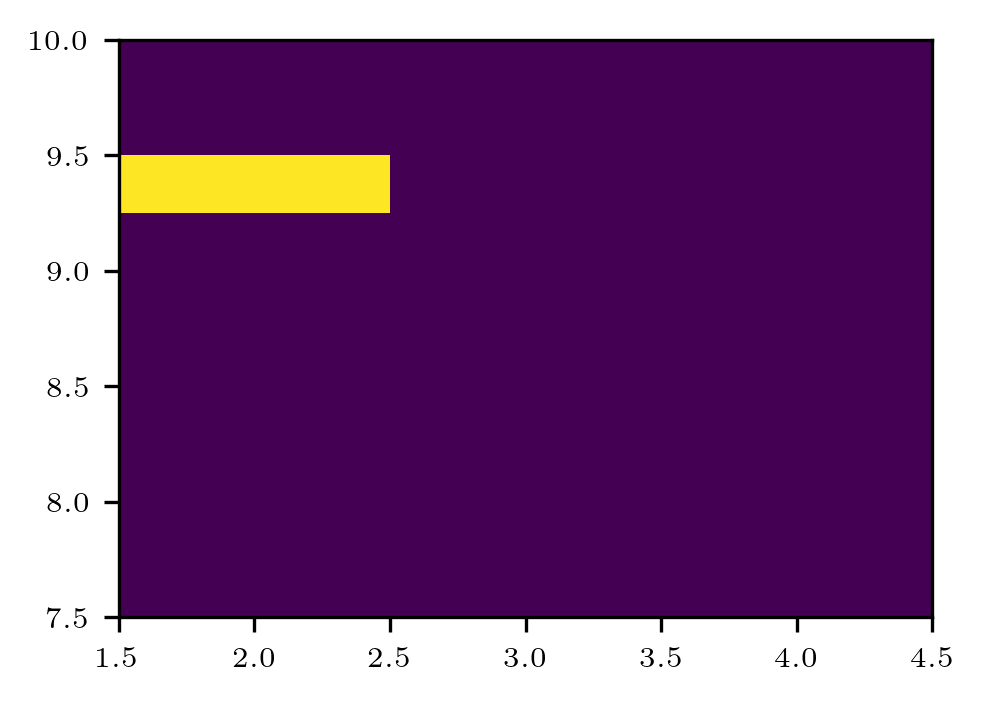

In [16]:
plt.imshow(w_all[..., 3], extent=(maps.ydegs.min()-0.5, maps.ydegs.max()+0.5, np.log10(maps.lambdas[0]), np.log10(maps.lambdas[-1])), aspect='auto', origin='lower')

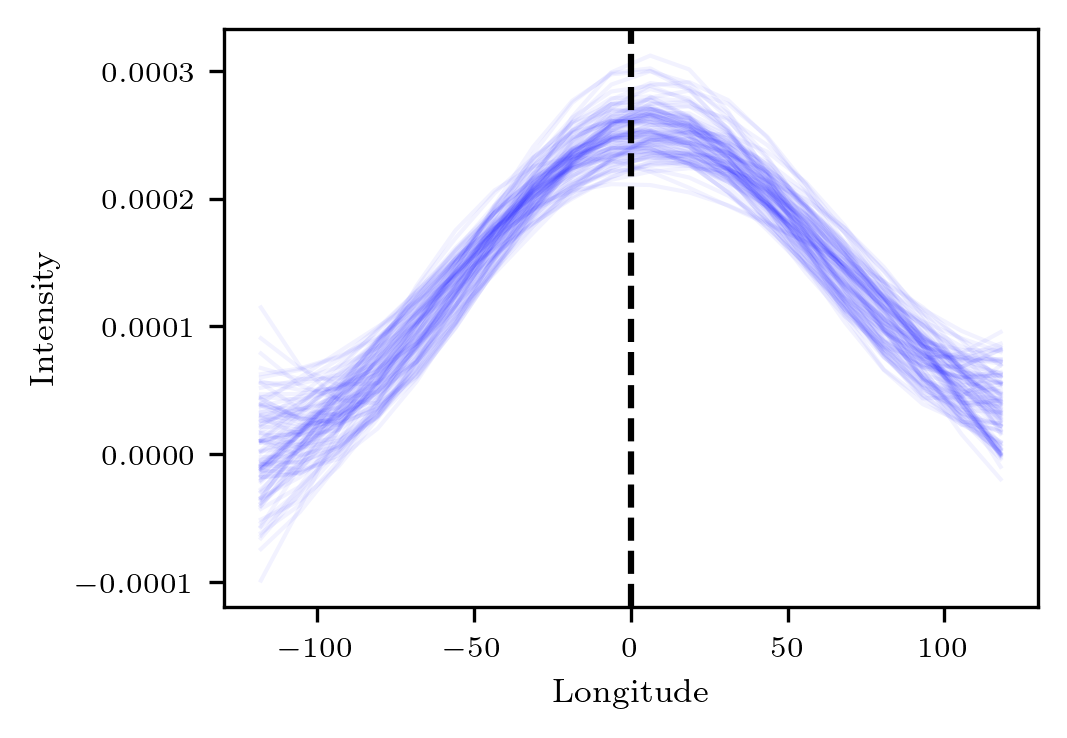

Text(0, 0.5, 'Intensity')

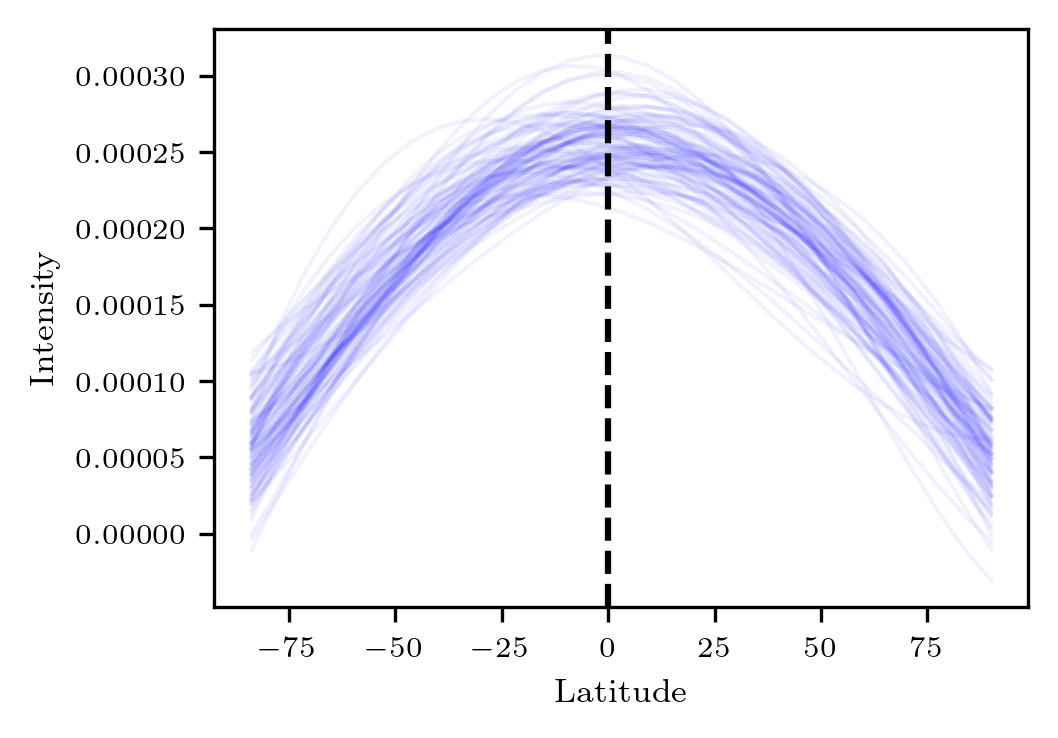

In [17]:
from spectralmap.mapping import expand_moll_values
i_wl = 0
I_plot = I_all_wl[i_wl]
I_cov_plot = I_cov_all_wl[i_wl]

N = 100
samples = np.random.multivariate_normal(I_plot, I_cov_plot, N)

n_lat, n_lon = maps.map_res, maps.map_res
lons, lats = np.linspace(-180, 180, n_lon), np.linspace(-90, 90, n_lat)

mask = maps.observed_mask

for i in range(N):
    plt.plot(lons, (expand_moll_values(samples[i], mask)).reshape(n_lat, n_lon)[n_lat//2], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Longitude')
plt.ylabel('Intensity')

plt.show()
for i in range(N):
    plt.plot(lats, (expand_moll_values(samples[i], mask)).reshape(n_lat, n_lon)[:, n_lon//2], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Latitude')
plt.ylabel('Intensity')

In [161]:
I_all_wl_sampled = []
target_n = 1000
batch_size = 1000

for i in range(nwl):
    I_sampled = []
    while len(I_sampled) < target_n:
        batch = np.random.multivariate_normal(
            I_all_wl[i], I_cov_all_wl[i], size=batch_size
        )
        positive_batch = batch[(batch > 0).all(axis=1)]

        n_need = target_n - len(I_sampled)
        if positive_batch.shape[0] > 0:
            I_sampled.extend(positive_batch[:n_need])

        print(f"{i}/{nwl}, {len(I_sampled)}")

    I_all_wl_sampled.append(np.asarray(I_sampled))
    print(f"Finished {i}/{nwl}")

0/25, 81
0/25, 170
0/25, 259
0/25, 351
0/25, 442
0/25, 525
0/25, 611
0/25, 695
0/25, 782
0/25, 873
0/25, 959
0/25, 1000
Finished 0/25
1/25, 4
1/25, 9
1/25, 11
1/25, 13
1/25, 17
1/25, 24
1/25, 28
1/25, 33
1/25, 37
1/25, 46
1/25, 54
1/25, 56
1/25, 59
1/25, 64
1/25, 65
1/25, 67
1/25, 71
1/25, 75
1/25, 81
1/25, 84
1/25, 89
1/25, 94
1/25, 98
1/25, 103
1/25, 105
1/25, 109
1/25, 116
1/25, 124
1/25, 125
1/25, 127
1/25, 135
1/25, 140
1/25, 143
1/25, 144
1/25, 147
1/25, 154
1/25, 156
1/25, 160
1/25, 165
1/25, 168
1/25, 172
1/25, 175
1/25, 177
1/25, 180
1/25, 181
1/25, 186
1/25, 192
1/25, 195
1/25, 201
1/25, 204
1/25, 207
1/25, 209
1/25, 213
1/25, 215
1/25, 218
1/25, 224
1/25, 227
1/25, 233
1/25, 237
1/25, 239
1/25, 246
1/25, 247
1/25, 255
1/25, 259
1/25, 262
1/25, 267
1/25, 268
1/25, 269
1/25, 273
1/25, 277
1/25, 284
1/25, 288
1/25, 291
1/25, 294
1/25, 298
1/25, 303
1/25, 305
1/25, 307
1/25, 310
1/25, 311
1/25, 313
1/25, 313
1/25, 313
1/25, 319
1/25, 323
1/25, 324
1/25, 328
1/25, 331
1/25, 338
1

In [162]:
amplitudes = np.ones(I_all_wl.shape[0])  # Placeholder for actual amplitude scaling per wavelength
F_all_wl_sampled = I_all_wl_sampled * amplitudes[:, None, None] * np.pi
F_all_wl = np.mean(F_all_wl_sampled, axis=1)
F_var_all_wl = np.std(F_all_wl_sampled, axis=1)**2
F_cov_all_wl = np.zeros((nwl, F_var_all_wl.shape[-1], F_var_all_wl.shape[-1]))
for i in range(nwl):
    F_cov_all_wl[i] = np.diag(F_var_all_wl[i])

In [163]:
(F_var_all_wl/np.diagonal(I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2, axis1=1, axis2=2)).mean()

0.6551376089404887

-1 258
0 100
1 100
Observable pixels: 458 of 900
F_regionals shape: (3, 25)
F_regional_errs shape: (3, 25)
labels unique (full map): [-1  0  1]
labels unique (observable only): [-1  0  1]


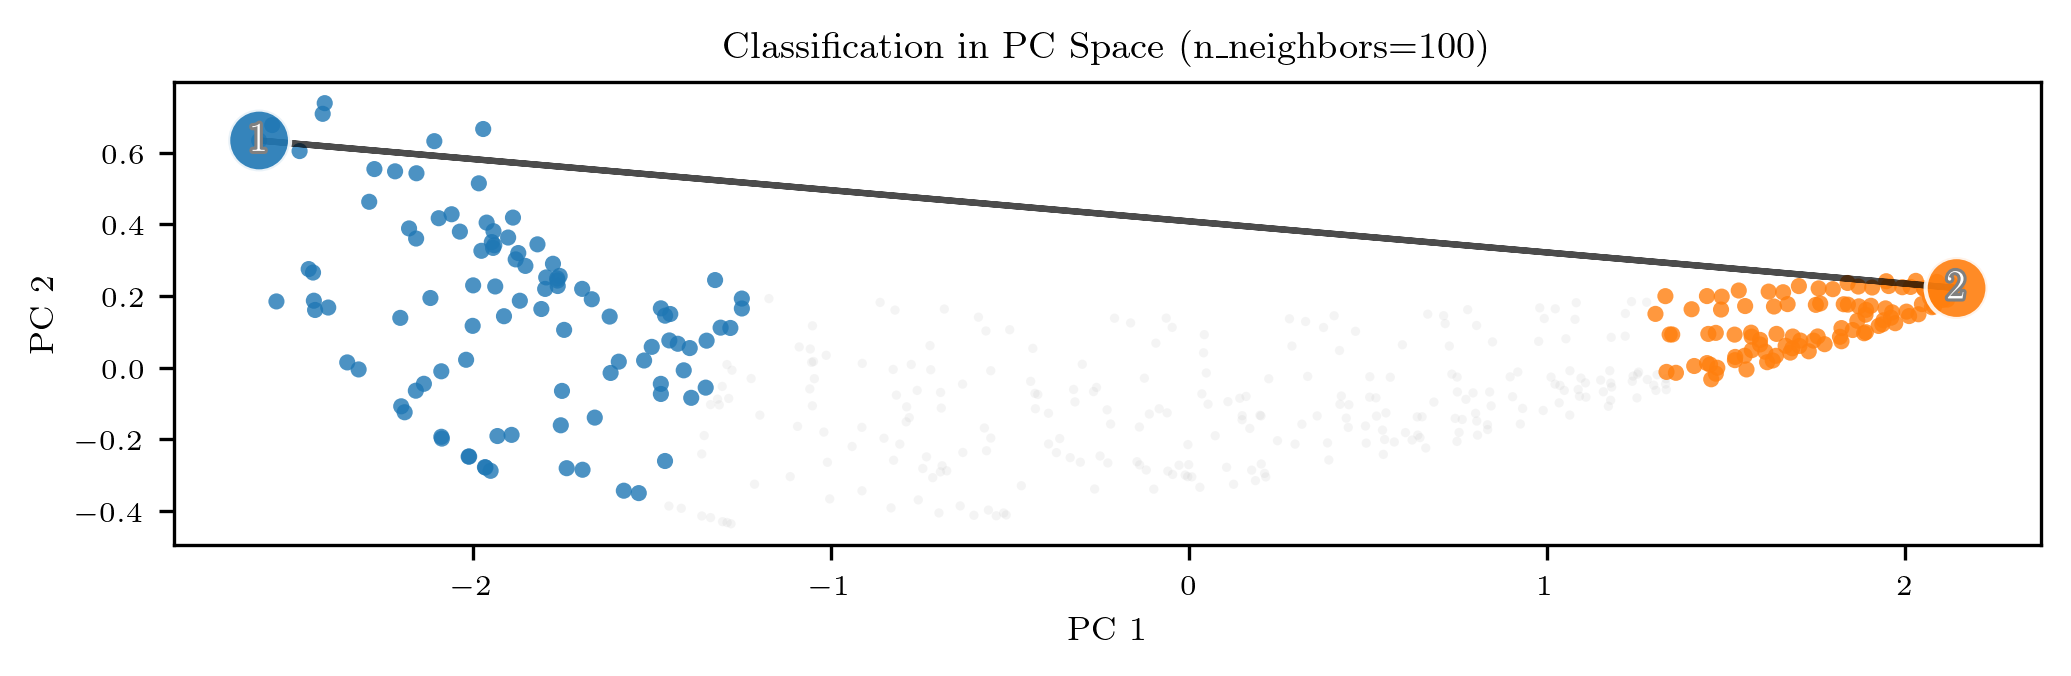

In [164]:
from spectralmap.cluster import find_clusters

# I_all_wl[I_all_wl < 1e-7] = 1e-7
# amplitudes = np.ones(I_all_wl.shape[0])  # Placeholder for actual amplitude scaling per wavelength
# F_all_wl = I_all_wl * amplitudes[:, None] * np.pi
# F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
# F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)

F_regionals, F_regional_errs, labels = find_clusters(
    F_all_wl,
    F_cov_all_wl,
    n_corners=2,
    n_neighbors=100,
 )

observed_mask = maps.observed_mask
print('Observable pixels:', int(observed_mask.sum()), 'of', observed_mask.size)
print('F_regionals shape:', F_regionals.shape)
print('F_regional_errs shape:', F_regional_errs.shape)
print('labels unique (full map):', np.unique(labels))
print('labels unique (observable only):', np.unique(labels))

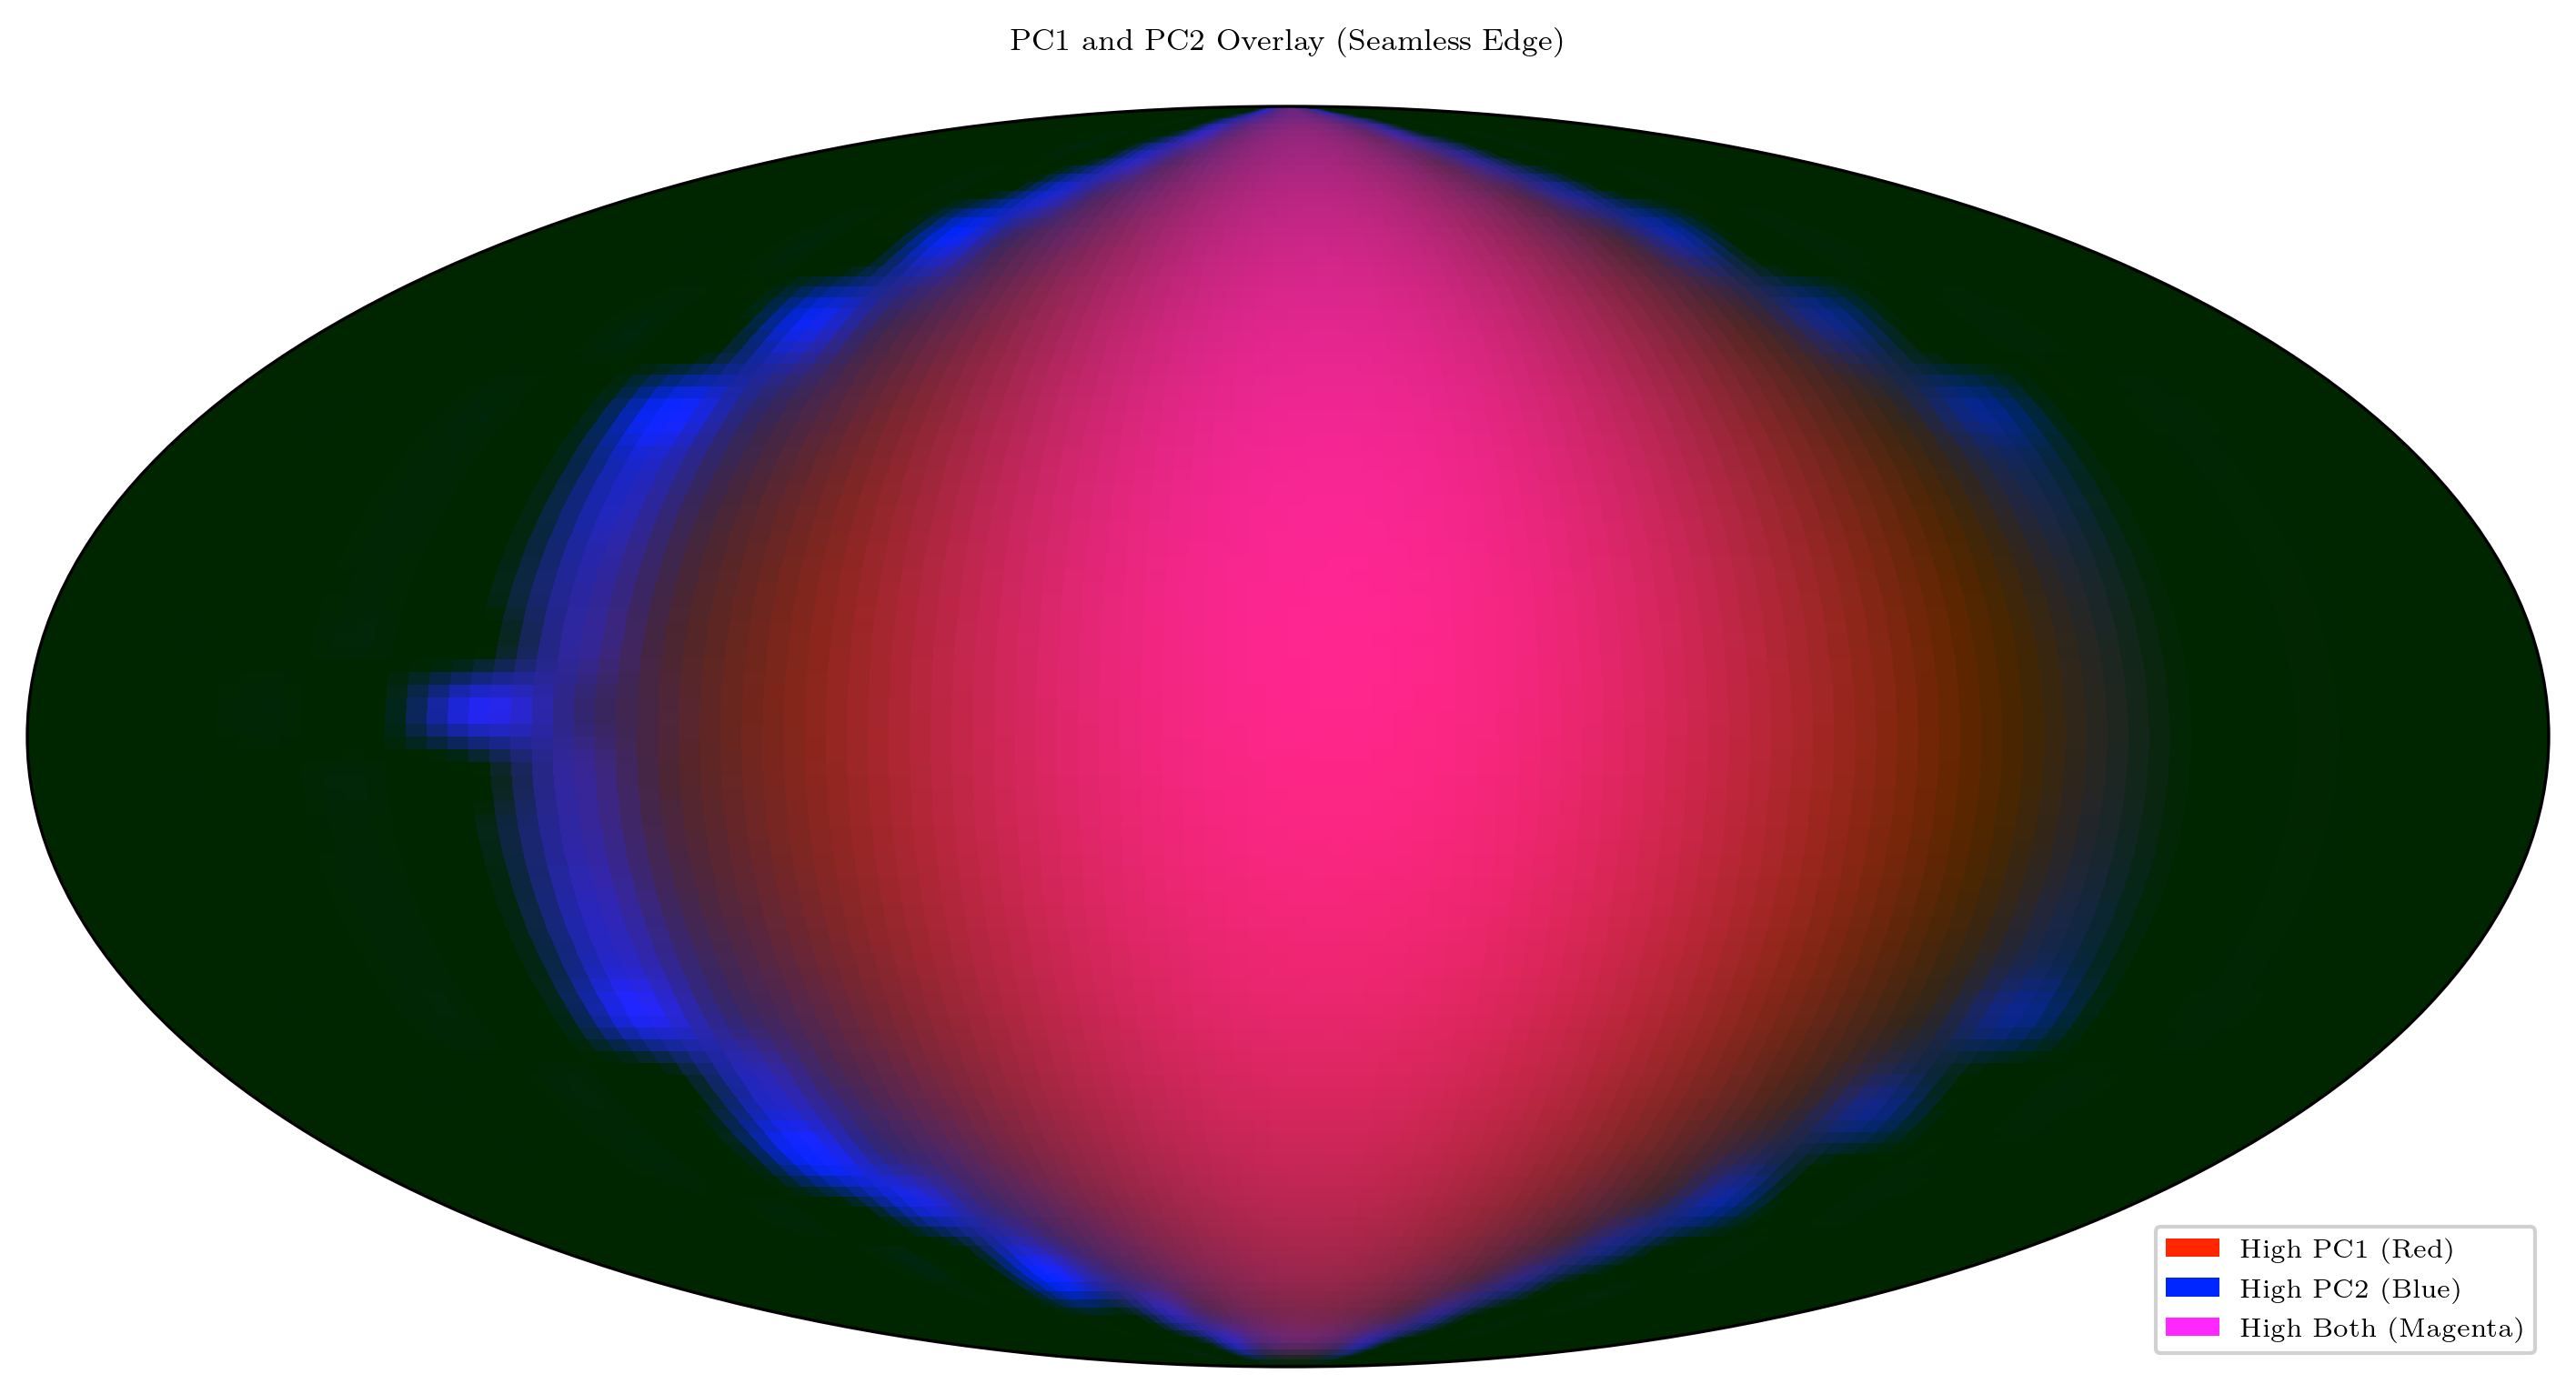

In [165]:
from sklearn.decomposition import PCA
from spectralmap.utilities import expand_moll_values, plot_mollweide_rgb_perfect_edges
pca = PCA(n_components=2)
PCs = pca.fit_transform(np.log(F_all_wl).T)  # shape: (n_wavelengths, 2)
pc1_scores = PCs[:, 0]
pc2_scores = PCs[:, 1]

mask_2d = (maps.lon > maps.observed_lon_range[0]) & (maps.lon < maps.observed_lon_range[1]) if maps.observed_lon_range is not None else np.ones_like(maps.lon, dtype=bool)

fig, ax = plot_mollweide_rgb_perfect_edges(pc1_scores, pc2_scores, mask_2d, upsample=4, extrapolate=False)
plt.show()

In [166]:
import numpy as np
from scipy.optimize import leastsq

# Physical Constants
c = 2.998e8   # Speed of light values from ExFig3.py
h = 6.626e-34 # Planck constant
kb = 1.381e-23 # Boltzmann constant

# Load throughput data once globally to avoid reading file in loops
try:
    throughput_data = np.loadtxt('../eigenspectra/ExFig3/niriss_order1.txt')
except OSError:
    print("Warning: Throughput file not found. Ensure path is correct.")
    throughput_data = None

def planck_radiance(wavelength_microns, temperature):
    """Calculates Blackbody radiance B_lambda in W/m^2/sr/m"""
    waves_m = wavelength_microns * 1e-6
    # Planck's Law
    bb = (2 * h * c**2 / waves_m**5) / (np.exp(h * c / (waves_m * kb * temperature)) - 1)
    return bb

def integrate_throughput(wavelength_microns, spectrum, throughput):
    """Integrates a spectrum over a bandpass defined by throughput."""
    # Normalize throughput to calculate the weighted mean flux
    denom = np.trapz(throughput, wavelength_microns)
    if not np.isfinite(denom) or np.isclose(denom, 0.0):
        return np.nan
    norm_throughput = throughput / denom
    integrated_val = np.trapz(spectrum * norm_throughput, wavelength_microns)
    return integrated_val

def calc_instrument_throughput(waves):
    """Interpolates throughput to given wavelengths using pre-loaded data."""
    if throughput_data is None:
        # Fallback or error if data not loaded
        return np.ones_like(waves)
    return np.interp(waves, throughput_data[:,0], throughput_data[:,1])

def residuals(T, target_radiance, wavelength_grid, throughput):
    """Residual function for the optimizer."""
    model_flux = planck_radiance(wavelength_grid, T)
    model_integrated = integrate_throughput(wavelength_grid, model_flux, throughput)
    return target_radiance - model_integrated

def compute_bin_widths_from_centers(central_waves):
    """Compute non-zero bin widths from bin centers using midpoint edges."""
    central_waves = np.asarray(central_waves)
    if central_waves.size < 2:
        return np.array([1e-6], dtype=float)
    edges = np.empty(central_waves.size + 1, dtype=float)
    edges[1:-1] = 0.5 * (central_waves[:-1] + central_waves[1:])
    edges[0] = central_waves[0] - 0.5 * (central_waves[1] - central_waves[0])
    edges[-1] = central_waves[-1] + 0.5 * (central_waves[-1] - central_waves[-2])
    widths = np.diff(edges)
    widths = np.where(widths > 0, widths, np.min(widths[widths > 0]))
    return widths

def eclipse_depth_to_brightness_temp(central_waves, bin_widths, eclipse_depth, r_p_r_s, T_star=6400.0):
    """
    Converts Eclipse Depth to Brightness Temperature element-wise.
    Optimized to pre-calculate grid integrations per wavelength bin.
    """
    
    eclipse_depth = np.asarray(eclipse_depth)
    central_waves = np.atleast_1d(central_waves)
    bin_widths = np.atleast_1d(bin_widths)
    
    temps = np.zeros_like(eclipse_depth)
    initial_guess = [2500.0]
    
    n_waves = len(central_waves)
    
    # Case 1: Multiple spectra (Regions x Wavelengths)
    if eclipse_depth.ndim == 2:
        n_regions = eclipse_depth.shape[0]
        # Iterate over wavelengths (outer loop)
        for i_wav in range(n_waves):
            cw = central_waves[i_wav]
            dw = bin_widths[i_wav]
            
            # --- Pre-calculation for this bin ---
            wave_grid = np.linspace(cw - dw/2.0, cw + dw/2.0, 1000)
            throughput_grid = calc_instrument_throughput(wave_grid)
            
            star_bb = planck_radiance(wave_grid, T_star)
            star_int = integrate_throughput(wave_grid, star_bb, throughput_grid)
            # ------------------------------------

            # Iterate over regions (inner loop) - only solving remains
            for i_reg in range(n_regions):
                depth = eclipse_depth[i_reg, i_wav]
                planet_int = star_int * depth / r_p_r_s**2
                if not np.isfinite(planet_int):
                    temps[i_reg, i_wav] = np.nan
                    continue

                res = leastsq(residuals, initial_guess, args=(planet_int, wave_grid, throughput_grid))
                temps[i_reg, i_wav] = res[0][0]
                
    # Case 2: Single spectrum (Wavelengths only)
    elif eclipse_depth.ndim == 1:
        for i_wav in range(n_waves):
            cw = central_waves[i_wav]
            dw = bin_widths[i_wav]
            depth = eclipse_depth[i_wav]
            
            wave_grid = np.linspace(cw - dw/2.0, cw + dw/2.0, 1000)
            throughput_grid = calc_instrument_throughput(wave_grid)
            
            star_bb = planck_radiance(wave_grid, T_star)
            star_int = integrate_throughput(wave_grid, star_bb, throughput_grid)
            
            planet_int = star_int * depth / r_p_r_s**2
            if not np.isfinite(planet_int):
                temps[i_wav] = np.nan
                continue
            
            res = leastsq(residuals, initial_guess, args=(planet_int, wave_grid, throughput_grid))
            temps[i_wav] = res[0][0]
            
    # Case 3: Scalar
    else:
        cw = central_waves[0]
        dw = bin_widths[0]
        depth = eclipse_depth
        wave_grid = np.linspace(cw - dw/2.0, cw + dw/2.0, 1000)
        throughput_grid = calc_instrument_throughput(wave_grid)
        star_bb = planck_radiance(wave_grid, T_star)
        star_int = integrate_throughput(wave_grid, star_bb, throughput_grid)
        planet_int = star_int * depth / r_p_r_s**2
        if not np.isfinite(planet_int):
            return np.nan
        res = leastsq(residuals, initial_guess, args=(planet_int, wave_grid, throughput_grid))
        return res[0][0]

    return temps

# --- Example Usage ---
RpRs = 0.09783 # From ExFig3.py
print("F_regionals shape:", F_regionals.shape)
print("F_regionals mean:", np.mean(F_regionals))

# Fix applied: Convert Starry Intensity to Eclipse Depth (Flux)
# Starry Intensity I integrates to Flux F = pi * I on the unit disk
# The conversion function expects Flux (Eclipse Depth), so we multiply by pi.
dlam = compute_bin_widths_from_centers(wl)
print("First three dlam:", dlam[:3])
Tb_all = eclipse_depth_to_brightness_temp(wl, dlam, F_regionals, RpRs)
Tb_upper_all = eclipse_depth_to_brightness_temp(wl, dlam, (F_regionals + F_regional_errs), RpRs)
Tb_lower_all = eclipse_depth_to_brightness_temp(wl, dlam, (F_regionals - F_regional_errs), RpRs)
print("Tb_all shape:", Tb_all.shape)
print("Tb_all mean:", np.mean(Tb_all))

F_regionals shape: (3, 25)
F_regionals mean: 0.001121316737240239
First three dlam: [0.07890907 0.07890907 0.07890907]
Tb_all shape: (3, 25)
Tb_all mean: 2537.5919288682103


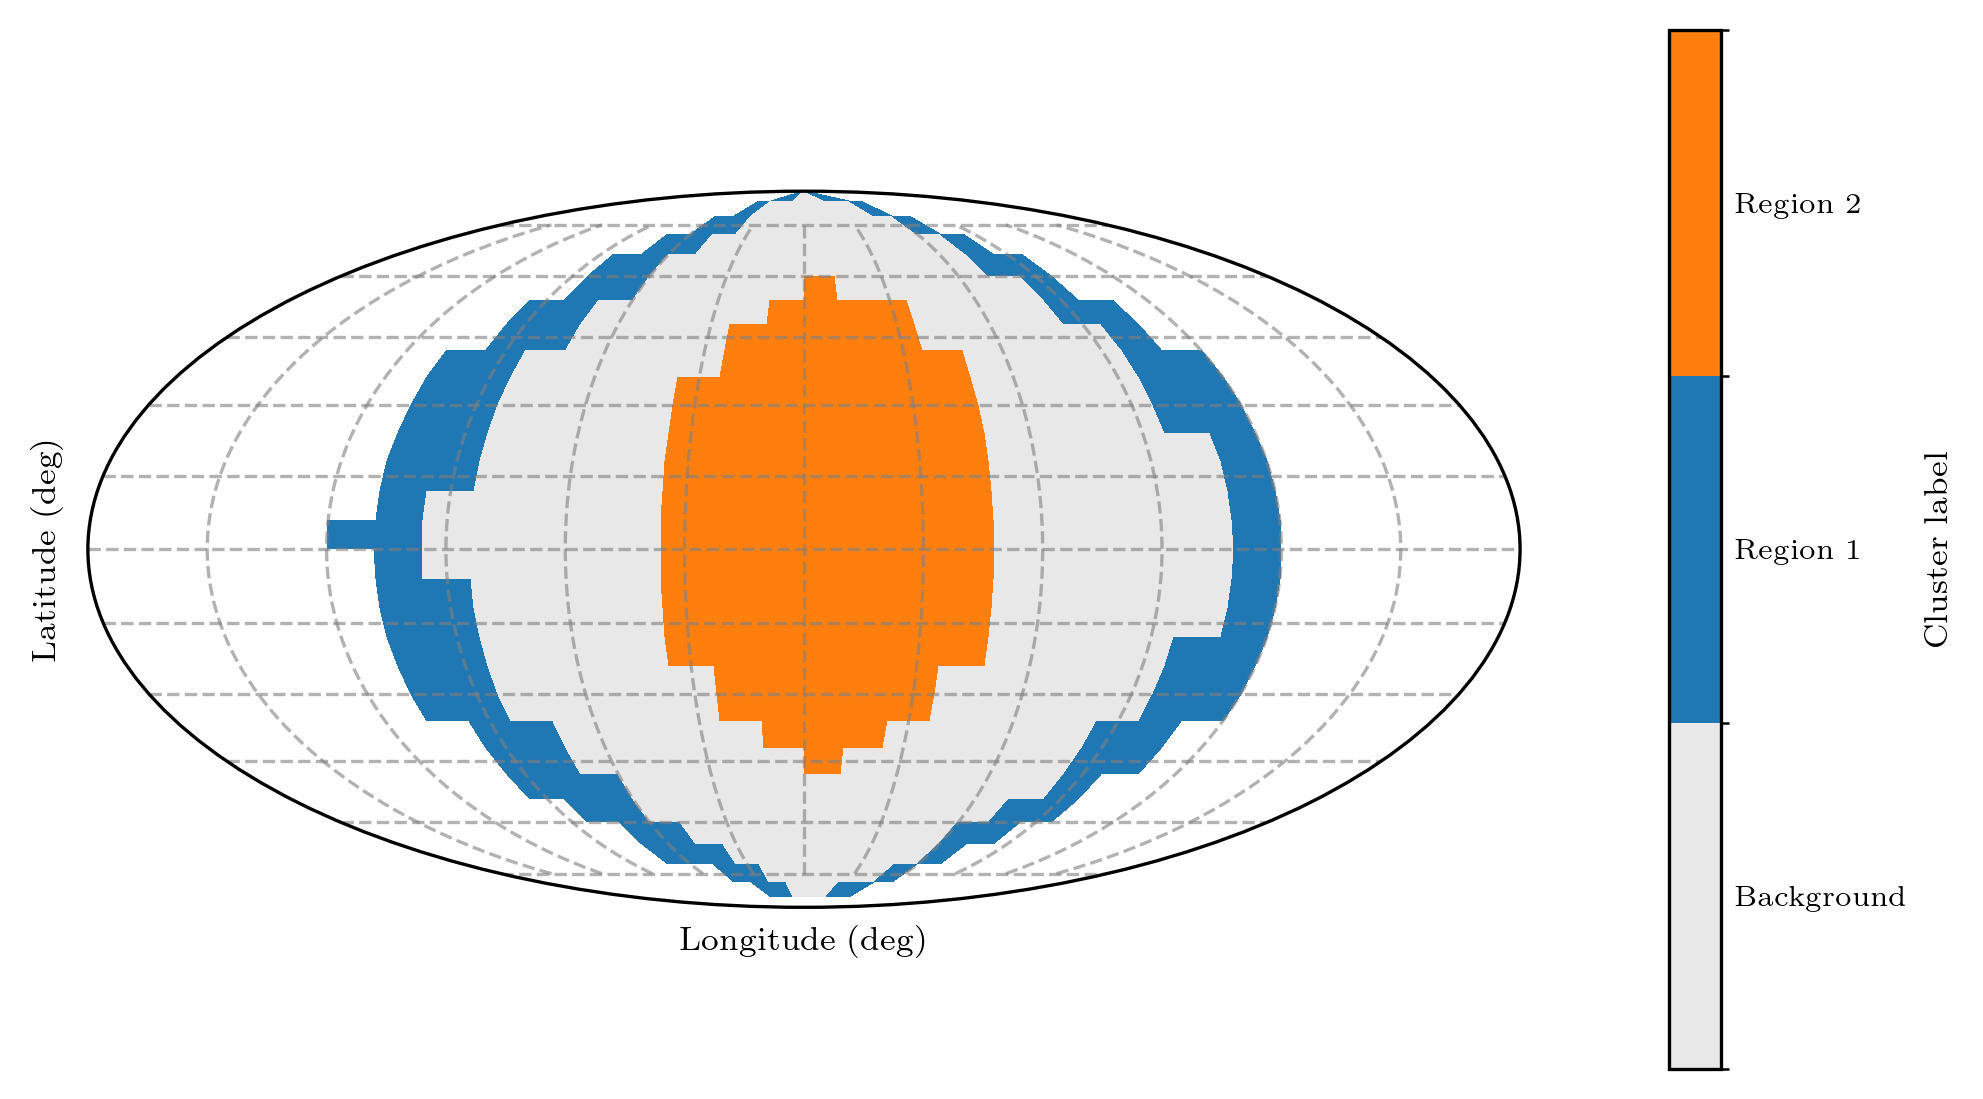

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from spectralmap.utilities import plot_mollweide_labels
from matplotlib import colors as mcolors

colors_list = ['#E8E8E8']  # Background
region_colors = plt.get_cmap('tab10').colors
N = len(F_regionals)
for i in range(N - 1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N - 1)]
cmap = mcolors.ListedColormap(colors_list)

fig, ax, pcm, cb = plot_mollweide_labels(
    labels_masked=labels,      # should be ints 0..N-1 on masked pixels
    moll_mask=maps.observed_mask,
    map_res=map.map_res,
    cmap=cmap,
    names=cluster_names,
    extrapolate=False
)

# output_dir = "paper_plots"
# os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, "S0136_recovered_regions.pdf")

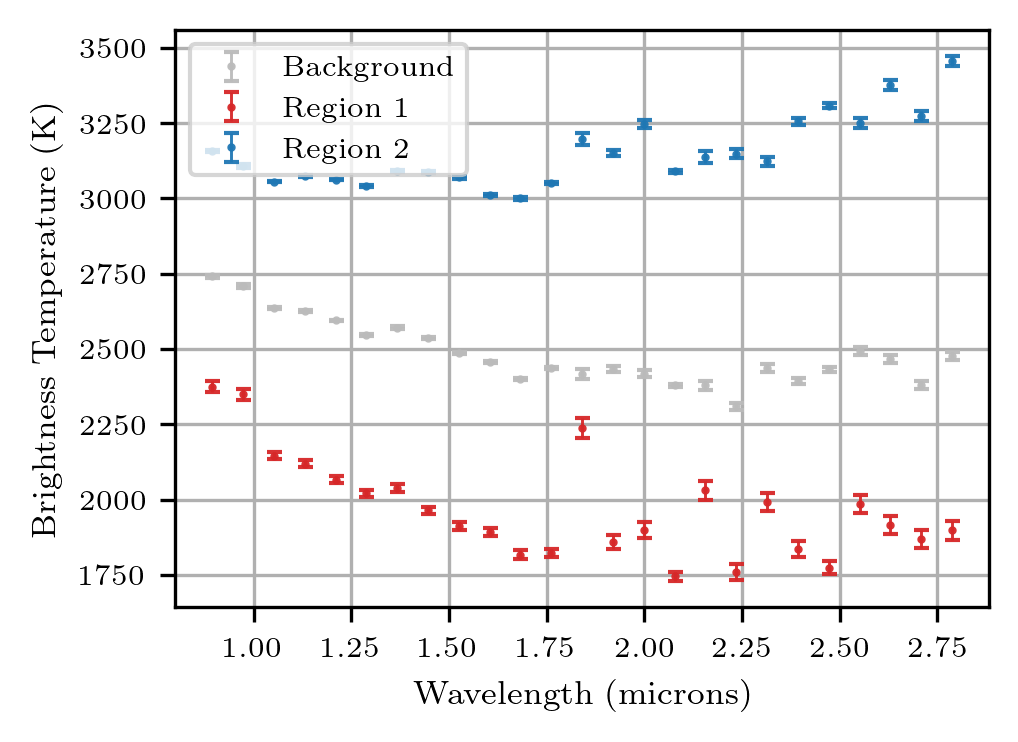

In [168]:
base_colors = ['#BBBBBB', '#D62728', '#1F77B4', '#9467BD', '#2CA02C', '#FF7F0E', '#8C564B']
for i in range(len(Tb_all)):
    if i == 0:
        label = 'Background'
    else:
        label = f'Region {i}'

    y = Tb_all[i]
    yerr_low = y - Tb_lower_all[i]
    yerr_high = Tb_upper_all[i] - y

    plt.errorbar(
        wl,
        y,
        yerr=np.vstack([yerr_low, yerr_high]),
        color=base_colors[i % len(base_colors)],
        fmt='o',
        ms=1,
        lw=1.0,
        elinewidth=0.7,
        capsize=1.8,
        alpha=0.95,
        label=label,
    )

plt.grid()
plt.xlabel('Wavelength (microns)')
plt.ylabel('Brightness Temperature (K)')
plt.legend()
# plt.ylim(2200, 3400)

In [169]:
np.mean(F_regionals/F_regional_errs)

104.66688660467625

In [170]:
sys = starry.System(pri, sec)

In [ ]:
# Prior on primary
pri_mu = np.zeros(pri.map.Ny)
pri_mu[0] = 1.0
pri_L = np.zeros(pri.map.Ny)
pri_L[0] = 1e-4
pri_L[1:] = 1e-7
pri.map.set_prior(mu=pri_mu, L=pri_L)

# Prior on secondary
sec_mu = np.zeros(sec.map.Ny)
sec_mu[0] = 0.0005
sec_L = np.zeros(sec.map.Ny)
sec_L[0] = 1e-1
sec_L[1:] = 1e-1
sec.map.set_prior(mu=sec_mu, L=sec_L)

In [ ]:
sys.set_data(flux=flux[i_wl], C=flux_err[i_wl] ** 2)
mu, cho_cov = sys.solve(t=time)
S = cho_cov.T @ cho_cov
# sys.show(t=time, window_pad=1,figsize=(5, 5),interval=10)

In [ ]:
sec.map.show(projection='rect', colorbar=True)
#-134.7 to 151.8 should be visible and positive

In [ ]:
plt.plot(time, flux[i_wl])
plt.plot(time, sys.flux(t=time))